# Transformer Prediction Model Diarrhoea Version 3
Date: 28/11/2022
Description: Transformer
Data: new data

In [1]:
# Install packages
!pip install -U scikit-learn
!pip install ftfy
# !pip install xlsxwriter 
# !pip install xlwt

In [2]:
# Imports
import tensorflow as tf 
# from google.colab import drive
import os

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense

import traceback
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from ftfy import fix_text
import warnings
warnings.simplefilter("ignore", UserWarning)

plt.rcParams['figure.figsize'] = [7, 3]

import math

# Input path

In [3]:
# Attach Google Drive for reading and saving files
# drive.mount('/content/drive')
prj_path = '/home/mlworker/Quang/HealthCare/Source_14012023_v4/'
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/opt_results_10022023_v4/"
data_path = prj_path + "data/new_data/DH/squeezed/"

# result path 
path = prj_path + "results/results_11022023/"
path_metrix = path + 'metrix/'
path_all_mix_cnn = path + 'all_mix_data/cnn/'
path_all_mix_lstm = path + 'all_mix_data/lstm/'
path_all_mix_lstm_att = path + 'all_mix_data/lstm_att/'

path_all_mix_tf= path + 'all_mix_data/tf/'

os.chdir(prj_path)

# Class Train and Support Functions for Preprocess

---



In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(42)

In [5]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 24 tháng = 2 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng 3 tháng
        self.n_predicted_month = 3
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        self.epochs = 300

args = Configuration()

# Pre-processing Functions

In [6]:
cities = [
    'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
        'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La','TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
         'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp']



def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(data_path+'squeezed_'+city+'.xlsx')  
    # Đoạn này rất quan trọng. Optimize không được đụng vào 36 tháng (2015-2017) để dự báo. 
    # Lúc train và predict thì ok. Lấy từ 1997 -2017. 
    # Function split data sẽ lấy 3 năm cuối làm test data theo config     
    city_result = city_result.loc[city_result['year_month'] < '2018-1-1'] 
    cities_data[city] = city_result
  return cities_data

dict_full_data = get_dict_all_city_data()

In [7]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name):
    """Returns Diarrhoea rate and climate data only""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases', 'province', 'year_month',
                                                        'Influenza_rates','Dengue_fever_rates',
                                                        'Influenza_cases','Dengue_fever_cases', 'year', 'month',
                                                        'population_male','population_female','population_urban',
                                                        'population_countryside','area','population_density',
                                                        'population_average','birth_rate','urban_water_usage_rate',
                                                        'clean_water_rate_all','poverty_rate','toilet_rate'
                                                        ], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data


def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Cơ bản dữ liệu bị thiếu sót rất nhiều: Như Điện Biên 1997 -2003 là thiếu dữ liệu về bệnh
    Hàm này sẽ tự sinh ra dữ liệu bị thiếu. Nếu tháng nào không có số liệu thì tính như sau:
    12 tháng đầu không có số liệu thì gán = 0
    tháng 13-24 không có số liệu, sẽ lấy giá trị của tháng cùng kỳ năm trước
    tháng từ 24 trở đi sẽ lấy giá trị nhỏ nhất của 2 tháng cùng kỳ trong 2 năm gần nhất.
    Do Điện Biên bằng 0 nên sau khi xử lý từ 1997 -2003 là đều = 0.  
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [8]:
# dict_full_data['Tiền Giang']
# city_TienGiang = get_city_data('Tiền Giang')

In [9]:
def split_data(data, look_back ):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]
    print('lookback', look_back)
    test = data[-args.test_size - look_back: ]
    return train, test

In [10]:
def to_supervised(data, d_in=args.look_back, d_out=args.n_predicted_month, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [11]:
def select_feature(train, specific_data):
    """Selects args.n_features top features using RFE"""
    train_X, train_y = to_supervised(train, d_in=1, d_out=1)
    train_X, train_y = np.squeeze(train_X), np.squeeze(train_y)
    rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=args.seed), n_features_to_select=args.n_features)
    fit = rfe.fit(train_X, train_y)
    important_features = list()
    print("Important Feature:")
    for i in range(len(fit.support_)):
        if fit.support_[i]:
            important_features.append(i)
            print(specific_data.columns[i])
    return np.array(important_features)

In [12]:
def get_data(train_np, test_np, batch_size, specific_data):
    """
    Returns important feature list and data formatted for input into Pytorch 
    models
    """
    important_features = select_feature(train_np, specific_data)

    train_X, train_y = to_supervised(train_np, features_list=important_features)
    test_X, test_y = to_supervised(test_np, features_list=important_features)
    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

    return important_features, train_loader, test_tensor

In [13]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_month)
        self.linear = nn.Linear(hidden_size, args.n_predicted_month)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_month)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

In [14]:
# Transformer Model
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=3, n_feature=3, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(n_feature, d_model)
        for pos in range(n_feature):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                if i + 1 < d_model:
                    pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.d_model)
        length = x.size(1)
        pe = Variable(self.pe[:, :length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_input, n_head, hidden_size, n_layers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.pe = PositionalEncoder(dropout=dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_input*n_head, args.n_predicted_month)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_month))
        self.loss_fn = nn.MSELoss()
    
    def forward(self, X_batch, y_batch=None):
        X_batch = self.pe(X_batch)
        X_batch = self.transformer_encoder(X_batch)
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        y_predicted = self.decoder(X_batch)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
        else:
            return y_predicted
        return X_batch
    
    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, device=args.device)
        return self.forward(X).squeeze()

In [15]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, city, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type    
        self.city = city    
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout, city)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout, city):
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        if model_type.lower() == 'lstm':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'lstm_attention':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type.lower() == 'cnn':
            model = MultivariateCNN(num_filters, dropout)
        elif model_type.lower() == 'transformers':
            model = TransformerModel(d_input=args.look_back, n_head=3, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)   
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None



    # Lưu model vào trong thư mục models
    def save_model_to(self, path = '', city =''):       
        torch.save(self.model, path)

    def load_model_to(self, path = ''):       
        return torch.load(path)

    def evaluate_model(self, np_data=None, plot=True, scaled=True, city=None, k_steps=None, y_scaler =None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data)
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        for k_steps in range(1, args.n_predicted_month + 1):
            y_predicted = []
            y_true = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, self.important_features]
                # yhat = self.model.predict(X.unsqueeze(0)).squeeze()

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
                y_true.append(tensor_data[index + args.look_back, -1].detach().cpu().numpy())

            y_predicted = y_scaler.inverse_transform(np.array(y_predicted).reshape(-1, 1)).reshape(-1, )
            y_true = y_scaler.inverse_transform(np.array(y_true).reshape(-1, 1)).reshape(-1, )

            

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            print('City: '+self.city+'  _algo:'+self.model_type+'  -MAE: '+str(mae))          
            if plot==True:
              plt.grid(True)
              plt.plot(y_predicted, label='predicted')
              plt.plot(y_true, label='actual')
              plt.title(f"k-steps = {k_steps} - city: "+self.city+'  _algo:'+self.model_type+'  -MAE: '+str(mae))
              plt.legend()
              plt.show()
                
            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)

        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

In [16]:
def convert_str_num_filter_array(str_filter = ''):  
  arr_filter = str_filter.split(',')  
  int_arr_filter= [int(x) for x in arr_filter]
  return int_arr_filter

# Get Optimized HyperParam

In [17]:

# prj_path_opt= '/content/drive/MyDrive/HealthCare/Source/optimize_hyperparam/opt_results/'
# opt_param_cnn = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_cnn.xlsx', index_col = 'City')
# opt_param_lstm = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_lstm.xlsx', index_col = 'City')
# opt_param_lstm_att = pd.read_excel(prj_path_opt+'diarrhoea_opt_hyperparam_lstm_att.xlsx', index_col = 'City')
opt_param_transformer = pd.read_excel(prj_path_opt+'/diarrhoea_opt_hyperparam_transformer.xlsx', index_col = 'City')

def get_opt_param_by_name(algo = 'transformer', city = None):
  # if algo == 'cnn':
  #   city_param = opt_param_cnn.loc[city]
  #   #load  param
  #   n_layers = ''
  #   hidden_size = ''
  #   num_filters = convert_str_num_filter_array(city_param['Num. filters'])
  #   dropout = float(city_param['Dropout rate'])
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  # elif algo == 'lstm':
  #   city_param = opt_param_lstm.loc[city]
  #   #load  param
  #   n_layers = int(city_param['n Layers'])
  #   hidden_size = int(city_param['Hiden Size'])
  #   num_filters = ''
  #   dropout = ''
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  # elif algo == 'lstm_attention':
  #   city_param = opt_param_lstm_att.loc[city]
  #   #load  param
  #   n_layers = int(city_param['n Layers'])
  #   hidden_size = int(city_param['Hiden Size'])
  #   num_filters = ''
  #   dropout = ''
  #   learning_rate = float(city_param['Learning rate'])
  #   epoch = int(city_param['Epochs'])
  #   lookback_window = int(city_param['Lookback Window'])
  if algo == 'transformer':
    city_param = opt_param_transformer.loc[city]
    #load  param
    n_layers = int(city_param['n Layers'])
    hidden_size = int(city_param['Hidden Size'])
    num_filters = ''
    dropout = float(city_param['Dropout rate'])
    learning_rate = float(city_param['Learning rate'])
    epoch = int(city_param['Epochs'])
    lookback_window = int(city_param['Lookback Window'])
  return n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window


In [18]:
# Manual Check param before train
# n_layers, hidden_size, num_filters, dropout, learning_rate, epoch, lookback_window= get_opt_param_by_name(algo='transformer', city='Cao Bằng')
# lookback_window,epoch, hidden_size, n_layers,learning_rate, num_filters, dropout

# Mix Result và Lưu vào folder tương ứng theo từng algo

In [19]:
def mix_results(city, algo, specific_data, y_pred_test, y_pred_train, lookback_window, iteration, rmse, mae, mape):
    new_cols = ["City","Algorithm","Run Seq","Observed","Train Prediction","Test Prediction","rmse","mae","mape"]
    mix_train_test_result = pd.DataFrame()
    mix_train_test_result['Observed']= specific_data['Diarrhoea_rates'] #default lenght 239
    mix_train_test_result = mix_train_test_result.reset_index(drop=True)  
    mix_train_test_result['City'] = city
    mix_train_test_result['Algorithm'] = algo
    mix_train_test_result['Run Seq'] = iteration 
    mix_train_test_result['Train Prediction'] = None
    mix_train_test_result['Test Prediction'] = None
    mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
    mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
    mix_train_test_result['rmse'] = rmse
    mix_train_test_result['mae'] = mae
    mix_train_test_result['mape'] = mape
    mix_train_test_result= mix_train_test_result.reindex(columns=new_cols)
    return mix_train_test_result

In [20]:
def save_results(all_mix_train_test_result, algo,city):
  if algo == 'cnn':  
    all_mix_train_test_result.to_excel(path_all_mix_cnn+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'lstm':
    all_mix_train_test_result.to_excel(path_all_mix_lstm+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'lstm_att':
    all_mix_train_test_result.to_excel(path_all_mix_lstm_att+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)
  elif algo == 'tf':
    all_mix_train_test_result.to_excel(path_all_mix_tf+'mix_train_test_data_'+city+'_'+algo+'.xlsx', index = False)


# Transformer train and run

<ipython-input-7-ba9a18586afe>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])


lookback 3
Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/420 - train_loss: 1.2266 - test_loss: 1.024076
Epoch: 105/420 - train_loss: 0.1147 - test_loss: 0.055892
Epoch: 210/420 - train_loss: 0.1143 - test_loss: 0.053294
Epoch: 315/420 - train_loss: 0.1147 - test_loss: 0.056875
Epoch: 419/420 - train_loss: 0.1150 - test_loss: 0.058655
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -MAE: 12.165229652374592


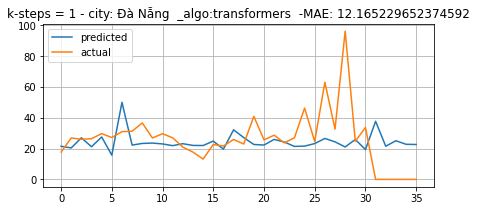

City: Đà Nẵng  _algo:transformers  -MAE: 13.535293265683528


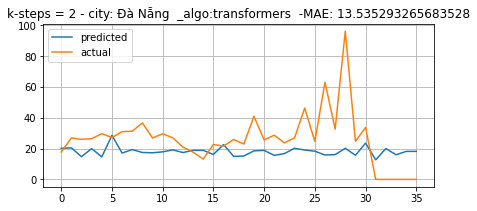

City: Đà Nẵng  _algo:transformers  -MAE: 14.966331271799739


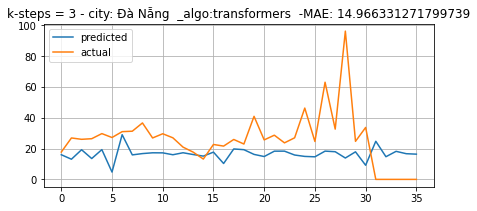

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -MAE: 41.531858627283235


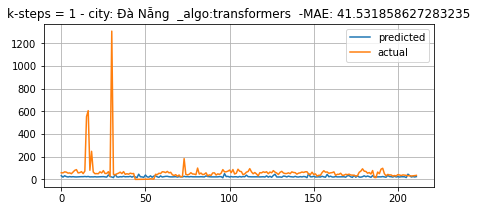

City: Đà Nẵng  _algo:transformers  -MAE: 46.92928941739526


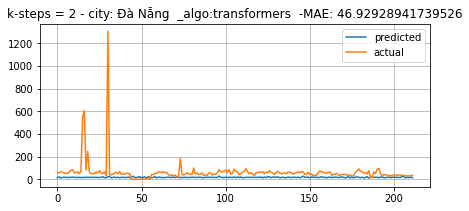

City: Đà Nẵng  _algo:transformers  -MAE: 48.10088459186249


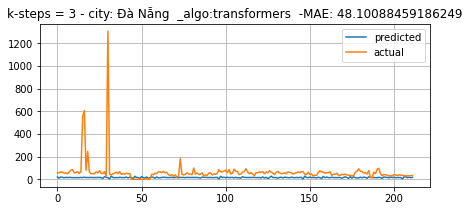

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/420 - train_loss: 0.8987 - test_loss: 0.669365
Epoch: 105/420 - train_loss: 0.1148 - test_loss: 0.056379
Epoch: 210/420 - train_loss: 0.1140 - test_loss: 0.056724
Epoch: 315/420 - train_loss: 0.1148 - test_loss: 0.058120
Epoch: 419/420 - train_loss: 0.1142 - test_loss: 0.057283
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -MAE: 35.107412043980815


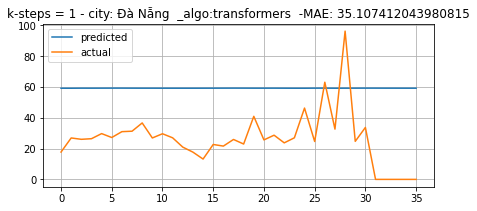

City: Đà Nẵng  _algo:transformers  -MAE: 32.85165843548135


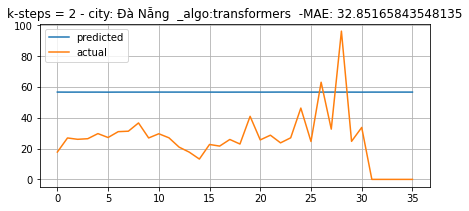

City: Đà Nẵng  _algo:transformers  -MAE: 34.41318807104264


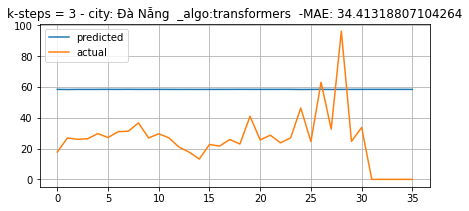

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -MAE: 27.869262974404716


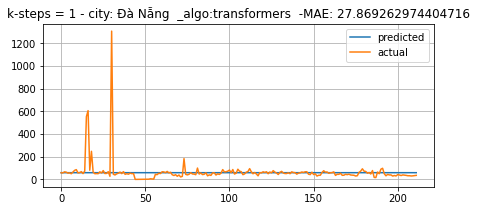

City: Đà Nẵng  _algo:transformers  -MAE: 27.26334917875267


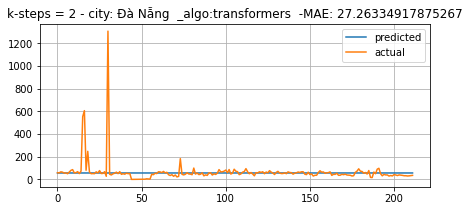

City: Đà Nẵng  _algo:transformers  -MAE: 27.6430111912879


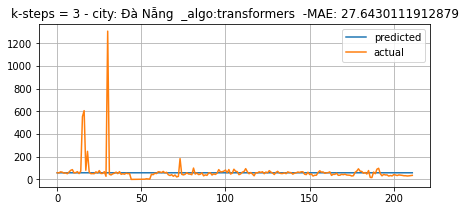

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/420 - train_loss: 0.8529 - test_loss: 0.599335
Epoch: 105/420 - train_loss: 0.1163 - test_loss: 0.058546
Epoch: 210/420 - train_loss: 0.1146 - test_loss: 0.055523
Epoch: 315/420 - train_loss: 0.1142 - test_loss: 0.058595
Epoch: 419/420 - train_loss: 0.1144 - test_loss: 0.055154
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -MAE: 29.600673129996736


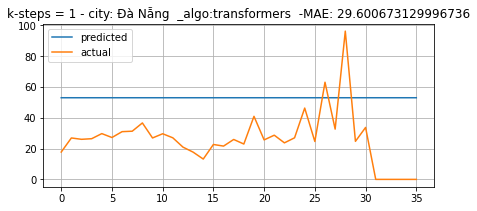

City: Đà Nẵng  _algo:transformers  -MAE: 32.46942267329841


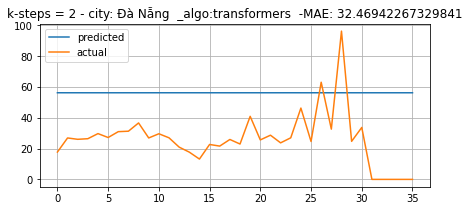

City: Đà Nẵng  _algo:transformers  -MAE: 34.65825346362643


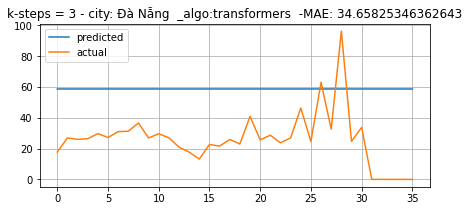

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -MAE: 26.920990082551675


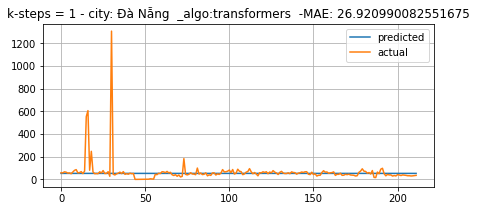

City: Đà Nẵng  _algo:transformers  -MAE: 27.196811263161695


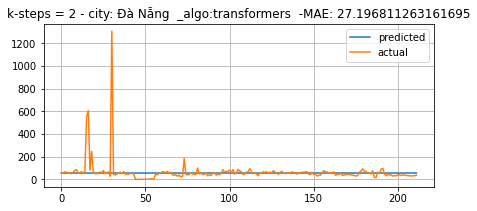

City: Đà Nẵng  _algo:transformers  -MAE: 27.719310543838247


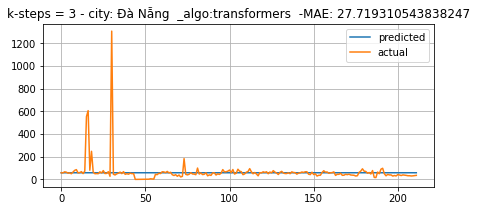

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/420 - train_loss: 1.0655 - test_loss: 0.649509
Epoch: 105/420 - train_loss: 0.1168 - test_loss: 0.062108
Epoch: 210/420 - train_loss: 0.1143 - test_loss: 0.058113
Epoch: 315/420 - train_loss: 0.1164 - test_loss: 0.060229
Epoch: 419/420 - train_loss: 0.1168 - test_loss: 0.065898
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -MAE: 20.335647557942


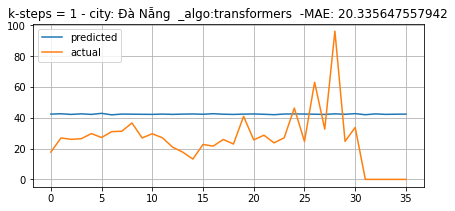

City: Đà Nẵng  _algo:transformers  -MAE: 24.306904371599607


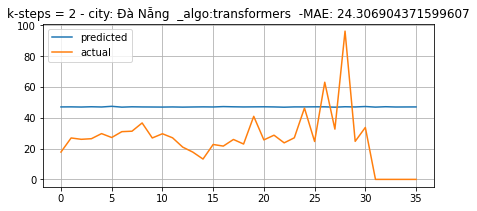

City: Đà Nẵng  _algo:transformers  -MAE: 15.36746008304852


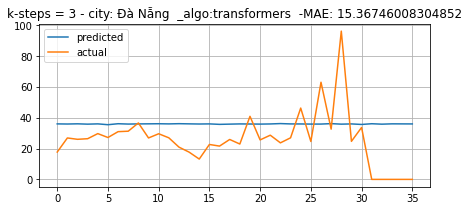

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -MAE: 28.980886689772674


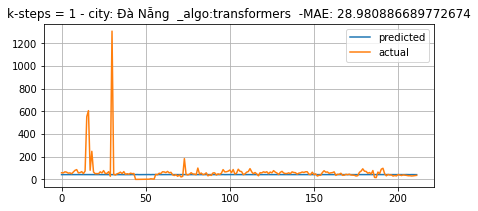

City: Đà Nẵng  _algo:transformers  -MAE: 27.46728827556618


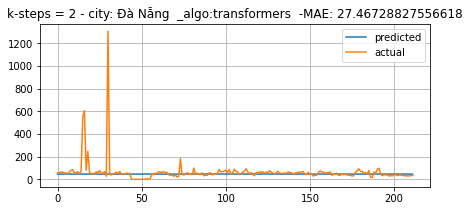

City: Đà Nẵng  _algo:transformers  -MAE: 32.32745378822611


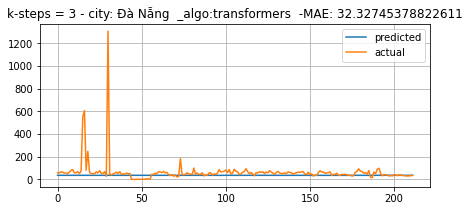

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Rainfall
Average_Humidity
Diarrhoea_rates
Đà Nẵng
Epoch:  0/420 - train_loss: 0.9088 - test_loss: 0.783417
Epoch: 105/420 - train_loss: 0.1159 - test_loss: 0.060561
Epoch: 210/420 - train_loss: 0.1143 - test_loss: 0.056671
Epoch: 315/420 - train_loss: 0.1141 - test_loss: 0.056021
Epoch: 419/420 - train_loss: 0.1145 - test_loss: 0.059038
Evaluate on test set: 
City: Đà Nẵng  _algo:transformers  -MAE: 13.653762381233411


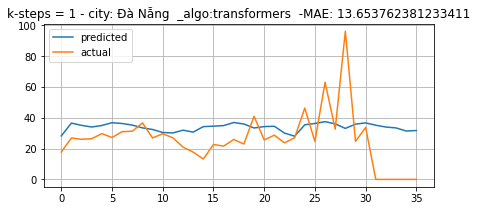

City: Đà Nẵng  _algo:transformers  -MAE: 15.63924684612999


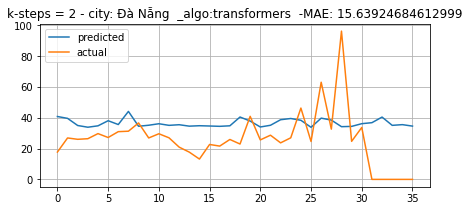

City: Đà Nẵng  _algo:transformers  -MAE: 15.4432886828831


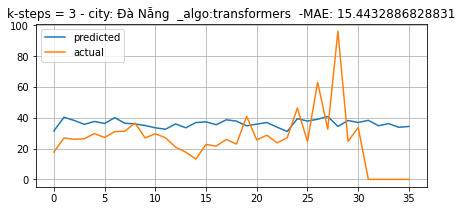

Evaluate on train set: 
City: Đà Nẵng  _algo:transformers  -MAE: 33.659902092201754


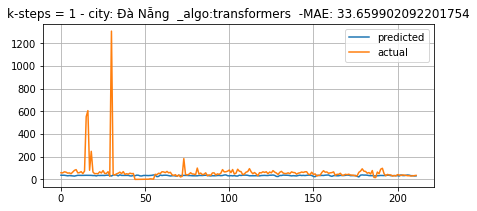

City: Đà Nẵng  _algo:transformers  -MAE: 32.16454505549494


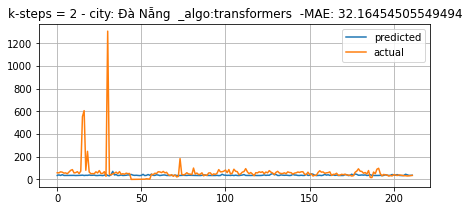

City: Đà Nẵng  _algo:transformers  -MAE: 32.017368836074944


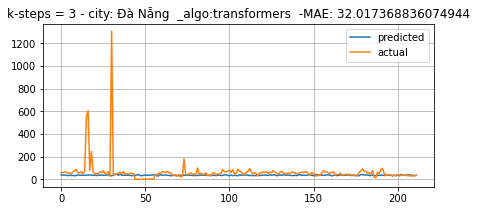

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/330 - train_loss: 0.9674 - test_loss: 0.638893
Epoch: 82/330 - train_loss: 0.1981 - test_loss: 0.339635
Epoch: 164/330 - train_loss: 0.1733 - test_loss: 0.375273
Epoch: 246/330 - train_loss: 0.1770 - test_loss: 0.363834
Epoch: 328/330 - train_loss: 0.1821 - test_loss: 0.370712
Epoch: 329/330 - train_loss: 0.1732 - test_loss: 0.356469
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 24.728107842496414


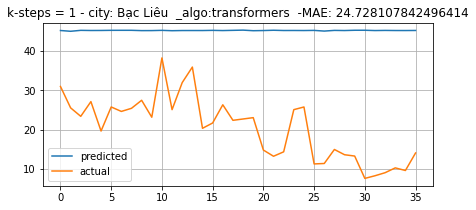

City: Bạc Liêu  _algo:transformers  -MAE: 24.891113586755033


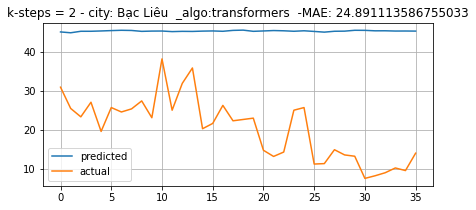

City: Bạc Liêu  _algo:transformers  -MAE: 27.760957563461208


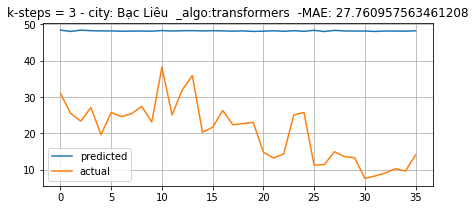

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 21.34953944149394


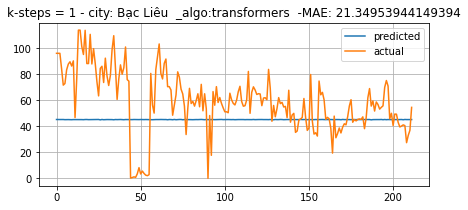

City: Bạc Liêu  _algo:transformers  -MAE: 21.299723746257804


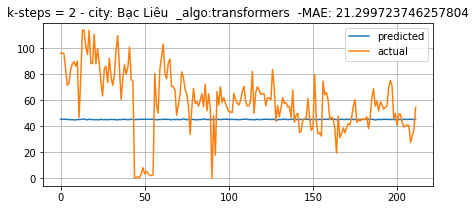

City: Bạc Liêu  _algo:transformers  -MAE: 19.935298160539997


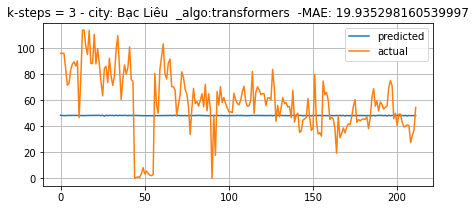

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/330 - train_loss: 0.7617 - test_loss: 0.613128
Epoch: 82/330 - train_loss: 0.1937 - test_loss: 0.377305
Epoch: 164/330 - train_loss: 0.1938 - test_loss: 0.376981
Epoch: 246/330 - train_loss: 0.1773 - test_loss: 0.335466
Epoch: 328/330 - train_loss: 0.1920 - test_loss: 0.340930
Epoch: 329/330 - train_loss: 0.1791 - test_loss: 0.345696
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 28.67768840018737


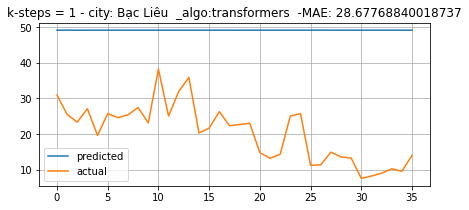

City: Bạc Liêu  _algo:transformers  -MAE: 29.409954265440433


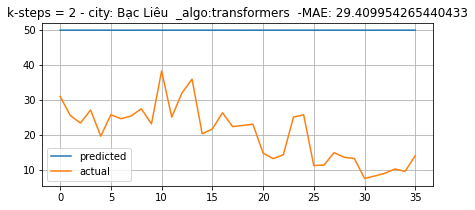

City: Bạc Liêu  _algo:transformers  -MAE: 28.23101464425089


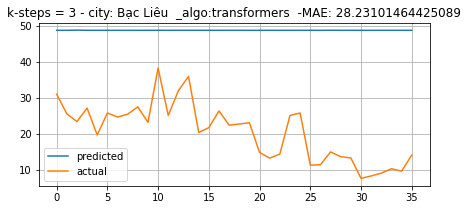

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 19.638112848781144


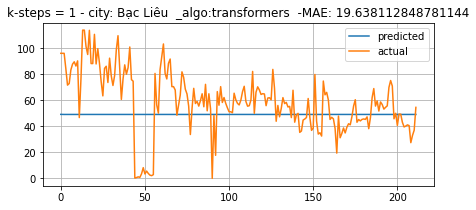

City: Bạc Liêu  _algo:transformers  -MAE: 19.38396909034099


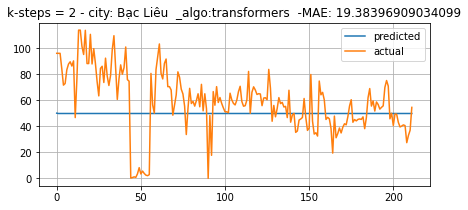

City: Bạc Liêu  _algo:transformers  -MAE: 19.7921049302028


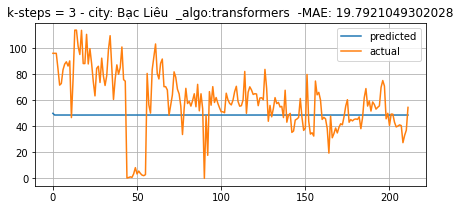

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/330 - train_loss: 0.7764 - test_loss: 0.579684
Epoch: 82/330 - train_loss: 0.1856 - test_loss: 0.376502
Epoch: 164/330 - train_loss: 0.1785 - test_loss: 0.357282
Epoch: 246/330 - train_loss: 0.1706 - test_loss: 0.383986
Epoch: 328/330 - train_loss: 0.1747 - test_loss: 0.346671
Epoch: 329/330 - train_loss: 0.1798 - test_loss: 0.341433
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 31.590986967064833


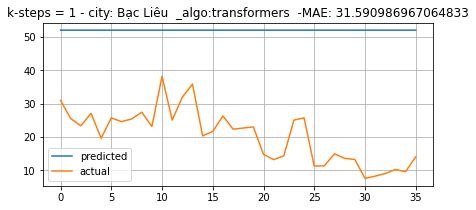

City: Bạc Liêu  _algo:transformers  -MAE: 32.963796530736005


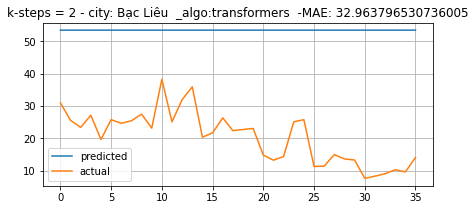

City: Bạc Liêu  _algo:transformers  -MAE: 31.51445880055766


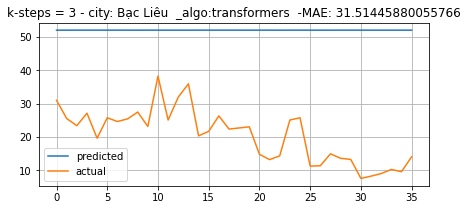

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 18.75491318145656


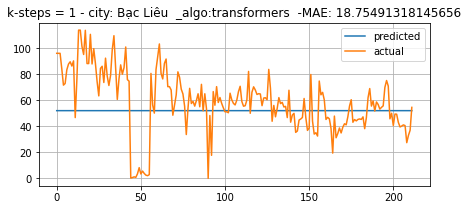

City: Bạc Liêu  _algo:transformers  -MAE: 18.406711968707544


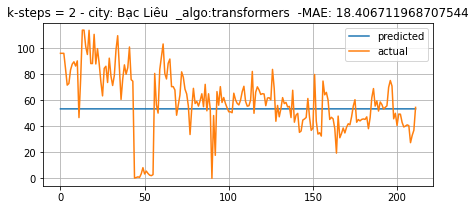

City: Bạc Liêu  _algo:transformers  -MAE: 18.773955109089854


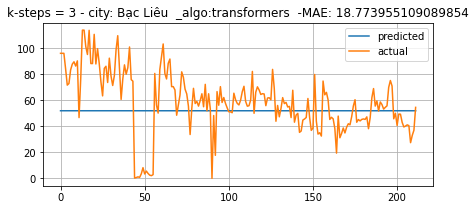

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/330 - train_loss: 0.7443 - test_loss: 0.699560
Epoch: 82/330 - train_loss: 0.1764 - test_loss: 0.377431
Epoch: 164/330 - train_loss: 0.1734 - test_loss: 0.356223
Epoch: 246/330 - train_loss: 0.1715 - test_loss: 0.384335
Epoch: 328/330 - train_loss: 0.1740 - test_loss: 0.354399
Epoch: 329/330 - train_loss: 0.1931 - test_loss: 0.349344
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 31.48749219192982


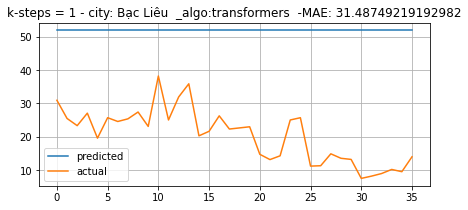

City: Bạc Liêu  _algo:transformers  -MAE: 19.89643949242225


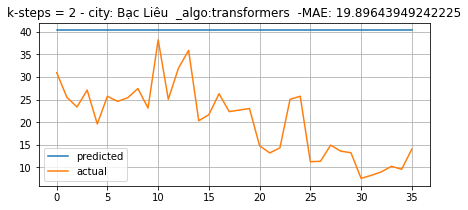

City: Bạc Liêu  _algo:transformers  -MAE: 31.828944010409423


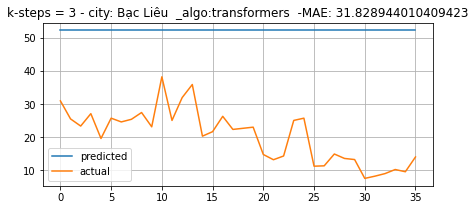

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 18.781189264721732


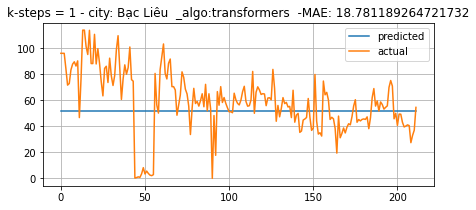

City: Bạc Liêu  _algo:transformers  -MAE: 24.297427615085848


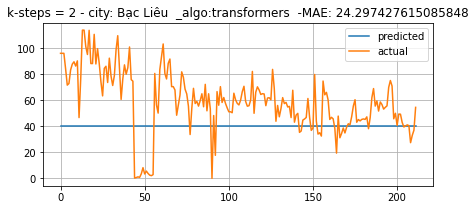

City: Bạc Liêu  _algo:transformers  -MAE: 18.69418836021149


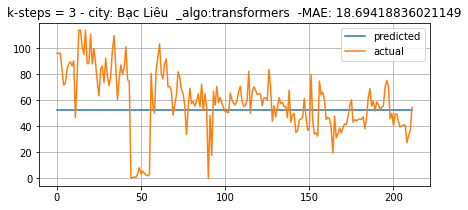

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Daily_Rainfall
n_hours_sunshine
Diarrhoea_rates
Bạc Liêu
Epoch:  0/330 - train_loss: 1.1733 - test_loss: 0.786009
Epoch: 82/330 - train_loss: 0.1779 - test_loss: 0.308891
Epoch: 164/330 - train_loss: 0.1833 - test_loss: 0.365182
Epoch: 246/330 - train_loss: 0.1713 - test_loss: 0.361305
Epoch: 328/330 - train_loss: 0.1705 - test_loss: 0.355606
Epoch: 329/330 - train_loss: 0.1722 - test_loss: 0.355430
Evaluate on test set: 
City: Bạc Liêu  _algo:transformers  -MAE: 21.700584697996423


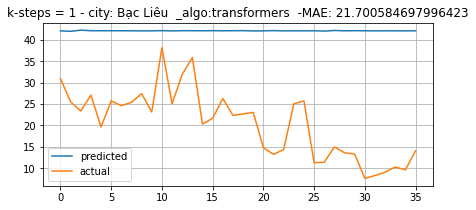

City: Bạc Liêu  _algo:transformers  -MAE: 21.71801633835488


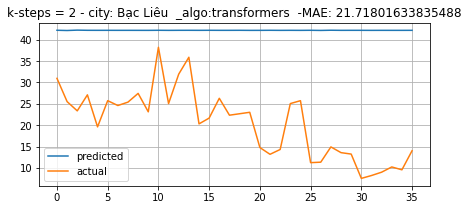

City: Bạc Liêu  _algo:transformers  -MAE: 23.792176516126993


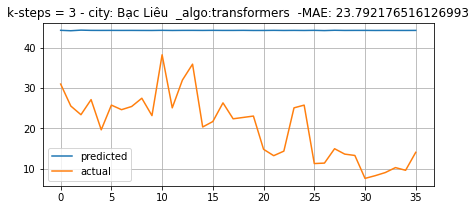

Evaluate on train set: 
City: Bạc Liêu  _algo:transformers  -MAE: 23.104264891381177


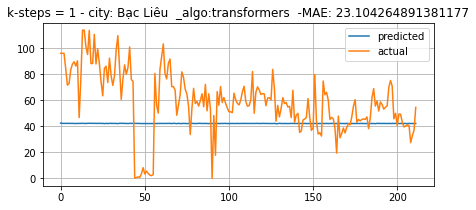

City: Bạc Liêu  _algo:transformers  -MAE: 23.117748938496764


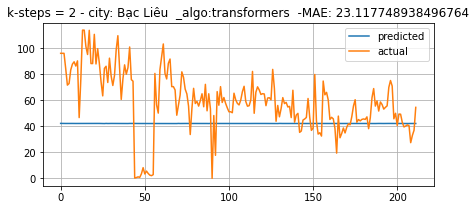

City: Bạc Liêu  _algo:transformers  -MAE: 21.85964681678872


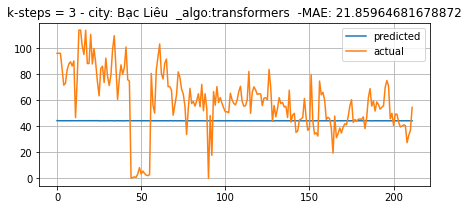

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/340 - train_loss: 1.3185 - test_loss: 1.163754
Epoch: 85/340 - train_loss: 0.3981 - test_loss: 0.343083
Epoch: 170/340 - train_loss: 0.1926 - test_loss: 0.157672
Epoch: 255/340 - train_loss: 0.1397 - test_loss: 0.089054
Epoch: 339/340 - train_loss: 0.1304 - test_loss: 0.074916
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 32.232373978916044


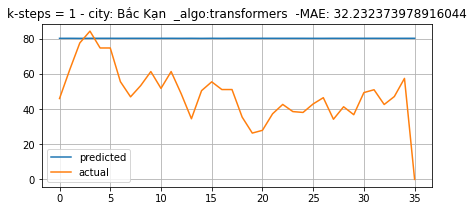

City: Bắc Kạn  _algo:transformers  -MAE: 16.157838502533004


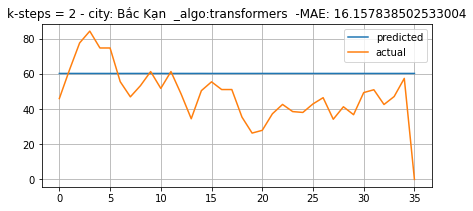

City: Bắc Kạn  _algo:transformers  -MAE: 23.26263427707934


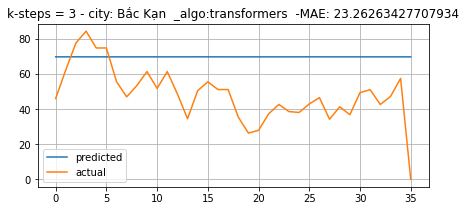

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 32.00271105415009


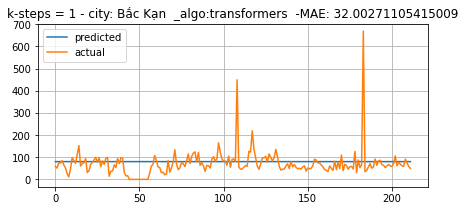

City: Bắc Kạn  _algo:transformers  -MAE: 28.775571621828398


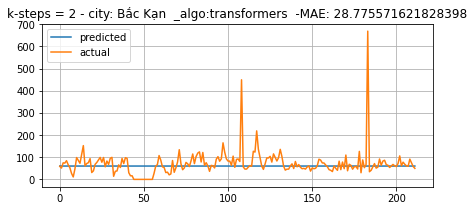

City: Bắc Kạn  _algo:transformers  -MAE: 29.07081572064728


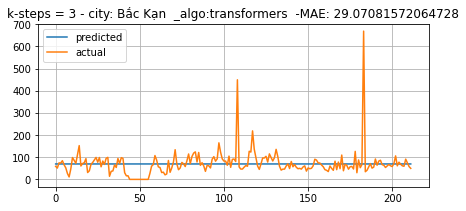

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/340 - train_loss: 1.3523 - test_loss: 1.022985
Epoch: 85/340 - train_loss: 0.4152 - test_loss: 0.357605
Epoch: 170/340 - train_loss: 0.1871 - test_loss: 0.158166
Epoch: 255/340 - train_loss: 0.1420 - test_loss: 0.096080
Epoch: 339/340 - train_loss: 0.1334 - test_loss: 0.082335
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 33.46747326390101


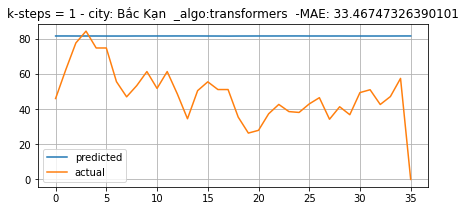

City: Bắc Kạn  _algo:transformers  -MAE: 34.45375437748402


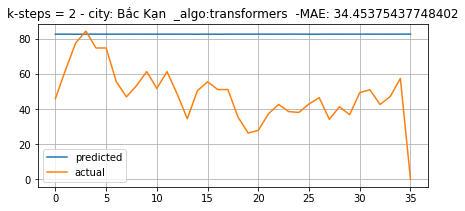

City: Bắc Kạn  _algo:transformers  -MAE: 20.97064447681218


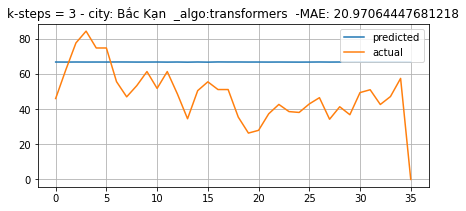

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 32.504634863936694


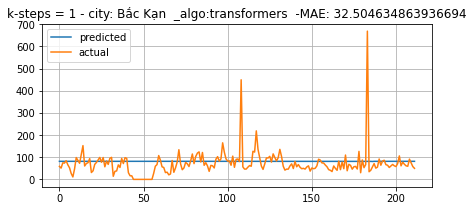

City: Bắc Kạn  _algo:transformers  -MAE: 32.92702214712542


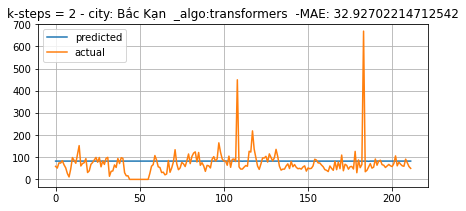

City: Bắc Kạn  _algo:transformers  -MAE: 28.718517979784423


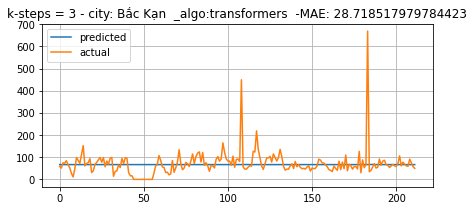

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/340 - train_loss: 1.2537 - test_loss: 1.455088
Epoch: 85/340 - train_loss: 0.3936 - test_loss: 0.357731
Epoch: 170/340 - train_loss: 0.1952 - test_loss: 0.164640
Epoch: 255/340 - train_loss: 0.1393 - test_loss: 0.092220
Epoch: 339/340 - train_loss: 0.1318 - test_loss: 0.079438
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 20.931784892670304


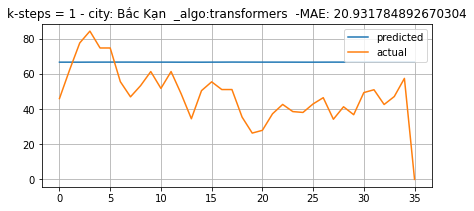

City: Bắc Kạn  _algo:transformers  -MAE: 33.17632235104354


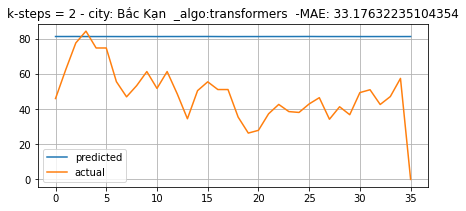

City: Bắc Kạn  _algo:transformers  -MAE: 24.28233899229486


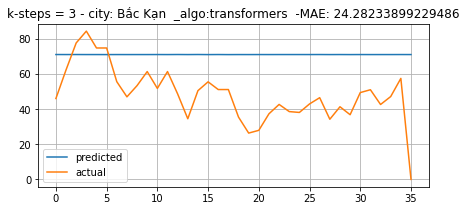

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 28.710947327523623


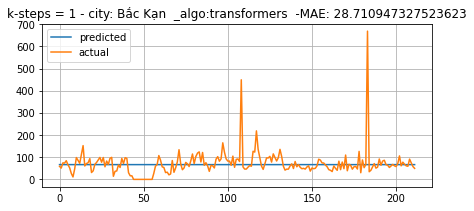

City: Bắc Kạn  _algo:transformers  -MAE: 32.38831727580362


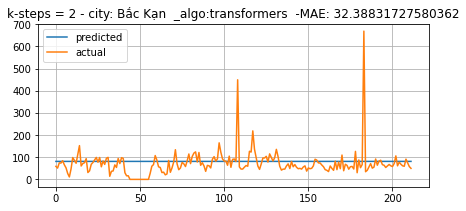

City: Bắc Kạn  _algo:transformers  -MAE: 29.290090035872645


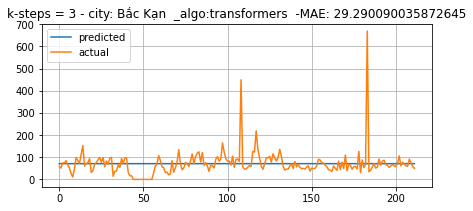

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/340 - train_loss: 1.5014 - test_loss: 1.099026
Epoch: 85/340 - train_loss: 0.4149 - test_loss: 0.353167
Epoch: 170/340 - train_loss: 0.1983 - test_loss: 0.159552
Epoch: 255/340 - train_loss: 0.1381 - test_loss: 0.091261
Epoch: 339/340 - train_loss: 0.1395 - test_loss: 0.075092
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 26.703086307933418


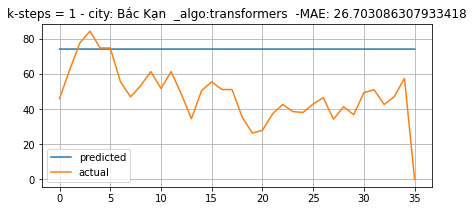

City: Bắc Kạn  _algo:transformers  -MAE: 26.110646381085207


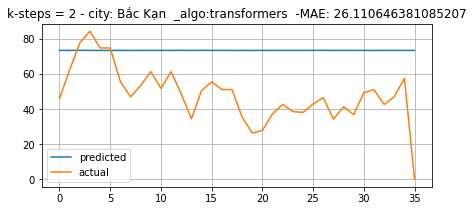

City: Bắc Kạn  _algo:transformers  -MAE: 20.29833372609357


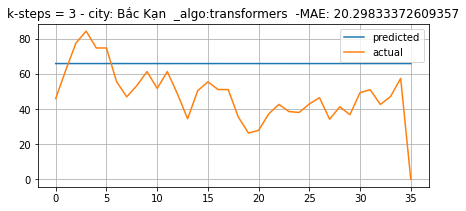

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 29.994924263670388


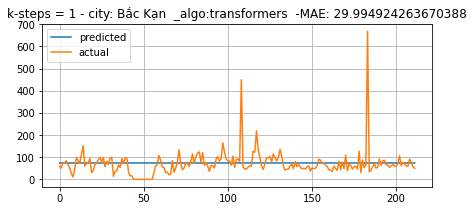

City: Bắc Kạn  _algo:transformers  -MAE: 29.809627026931953


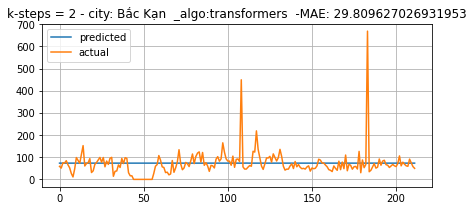

City: Bắc Kạn  _algo:transformers  -MAE: 28.665640310075087


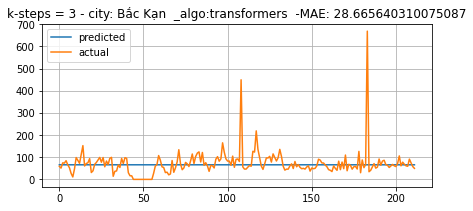

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Min_Average_Temperature
Max_Absolute_Temperature
Diarrhoea_rates
Bắc Kạn
Epoch:  0/340 - train_loss: 1.7230 - test_loss: 3.121277
Epoch: 85/340 - train_loss: 0.4902 - test_loss: 0.383447
Epoch: 170/340 - train_loss: 0.2122 - test_loss: 0.171218
Epoch: 255/340 - train_loss: 0.1434 - test_loss: 0.090939
Epoch: 339/340 - train_loss: 0.1335 - test_loss: 0.076538
Evaluate on test set: 
City: Bắc Kạn  _algo:transformers  -MAE: 29.925360293919695


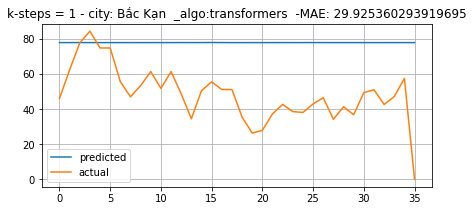

City: Bắc Kạn  _algo:transformers  -MAE: 28.728087398430464


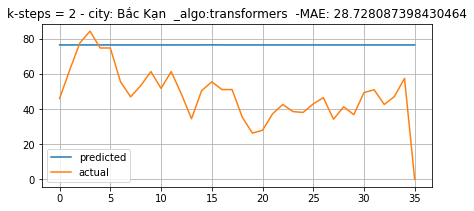

City: Bắc Kạn  _algo:transformers  -MAE: 20.625811339422764


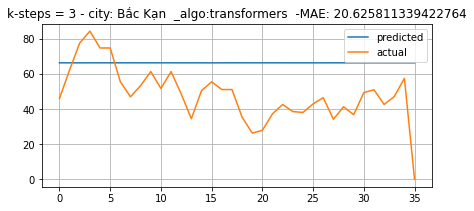

Evaluate on train set: 
City: Bắc Kạn  _algo:transformers  -MAE: 31.102351538377206


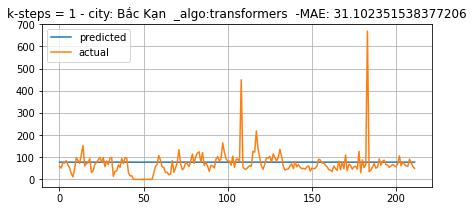

City: Bắc Kạn  _algo:transformers  -MAE: 30.672487147534653


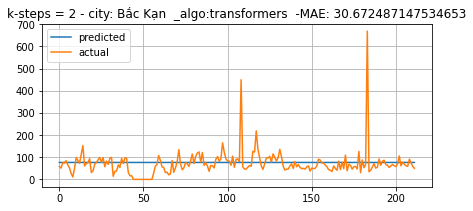

City: Bắc Kạn  _algo:transformers  -MAE: 28.688207685378522


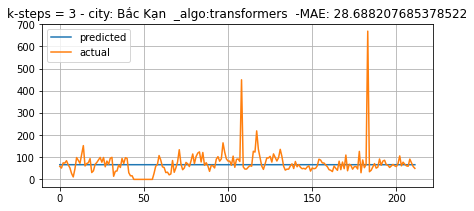

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/480 - train_loss: 1.4371 - test_loss: 1.028209
Epoch: 120/480 - train_loss: 0.3111 - test_loss: 0.445629
Epoch: 240/480 - train_loss: 0.3358 - test_loss: 0.477703
Epoch: 360/480 - train_loss: 0.3025 - test_loss: 0.425329
Epoch: 479/480 - train_loss: 0.2989 - test_loss: 0.435988
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 44.13499689115392


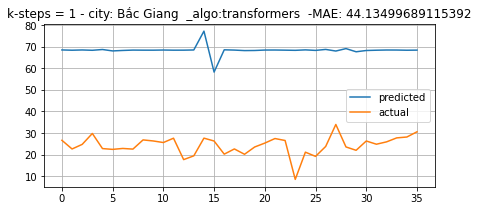

City: Bắc Giang  _algo:transformers  -MAE: 35.46947357061652


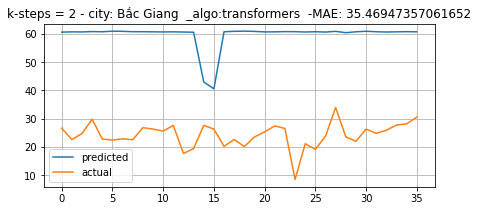

City: Bắc Giang  _algo:transformers  -MAE: 39.61414315587987


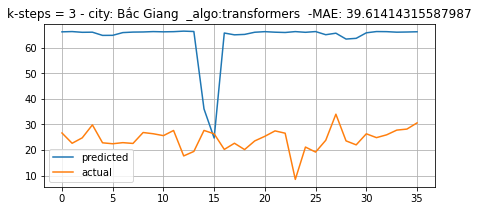

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 27.7818206032443


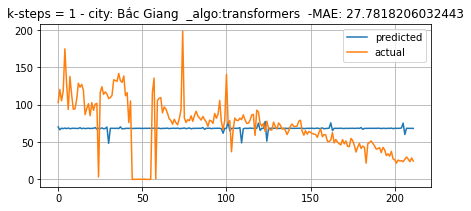

City: Bắc Giang  _algo:transformers  -MAE: 30.343146953914445


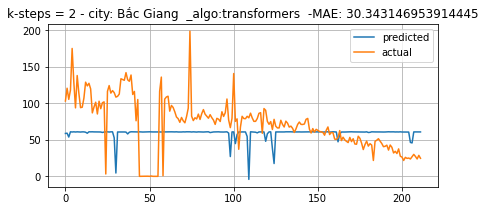

City: Bắc Giang  _algo:transformers  -MAE: 29.898132630061152


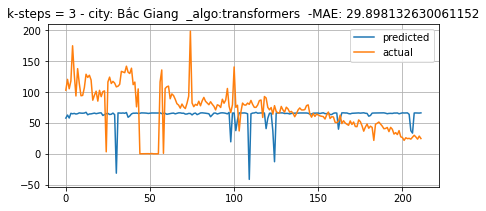

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/480 - train_loss: 1.1610 - test_loss: 0.938555
Epoch: 120/480 - train_loss: 0.3069 - test_loss: 0.464833
Epoch: 240/480 - train_loss: 0.3026 - test_loss: 0.463101
Epoch: 360/480 - train_loss: 0.3010 - test_loss: 0.469158
Epoch: 479/480 - train_loss: 0.3214 - test_loss: 0.441460
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 35.317898797810344


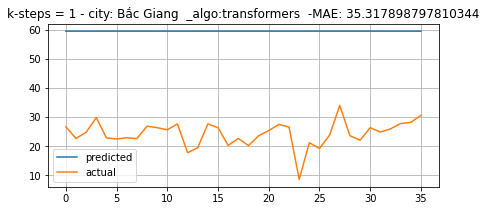

City: Bắc Giang  _algo:transformers  -MAE: 35.834843974737986


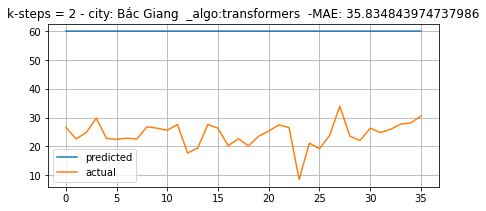

City: Bắc Giang  _algo:transformers  -MAE: 36.79186255706687


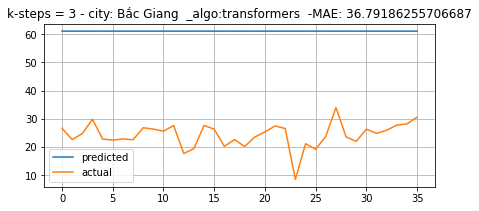

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 29.512676088737184


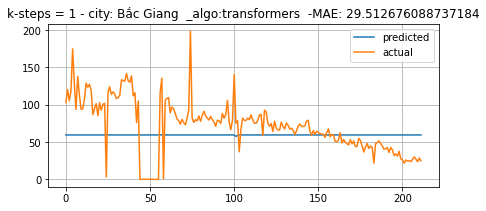

City: Bắc Giang  _algo:transformers  -MAE: 29.34013105582504


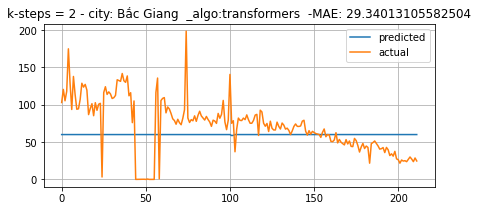

City: Bắc Giang  _algo:transformers  -MAE: 29.049059705340188


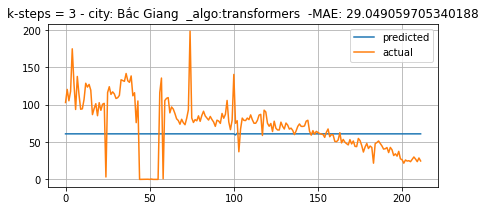

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/480 - train_loss: 1.4372 - test_loss: 1.011077
Epoch: 120/480 - train_loss: 0.2977 - test_loss: 0.459995
Epoch: 240/480 - train_loss: 0.3044 - test_loss: 0.460029
Epoch: 360/480 - train_loss: 0.3064 - test_loss: 0.443652
Epoch: 479/480 - train_loss: 0.3189 - test_loss: 0.453610
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 36.041901409100234


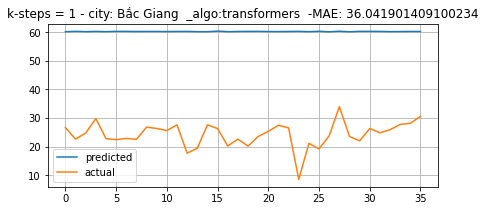

City: Bắc Giang  _algo:transformers  -MAE: 31.936893902858124


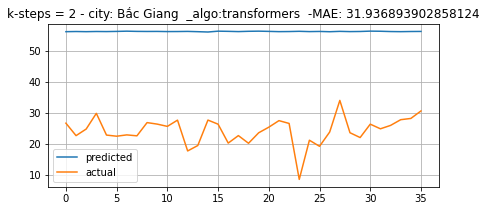

City: Bắc Giang  _algo:transformers  -MAE: 35.82153764752588


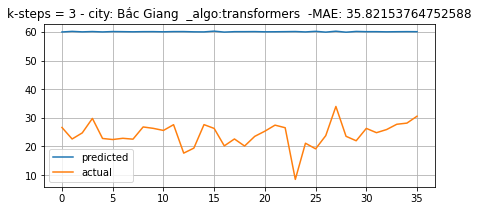

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 29.20960936692789


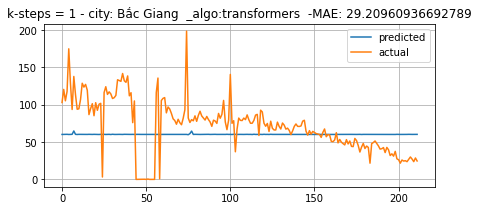

City: Bắc Giang  _algo:transformers  -MAE: 30.63143731086816


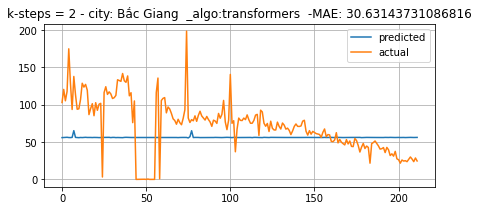

City: Bắc Giang  _algo:transformers  -MAE: 29.293258013039992


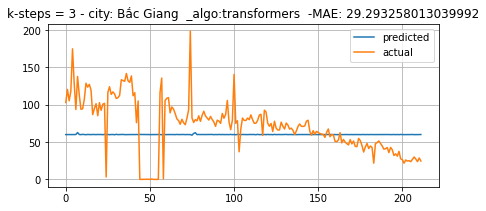

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/480 - train_loss: 1.1064 - test_loss: 0.769926
Epoch: 120/480 - train_loss: 0.3077 - test_loss: 0.454644
Epoch: 240/480 - train_loss: 0.2990 - test_loss: 0.452606
Epoch: 360/480 - train_loss: 0.2981 - test_loss: 0.427412
Epoch: 479/480 - train_loss: 0.3022 - test_loss: 0.429952
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 36.633416177868696


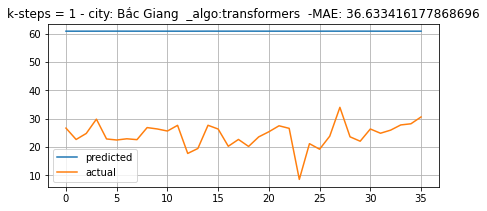

City: Bắc Giang  _algo:transformers  -MAE: 40.57733520792709


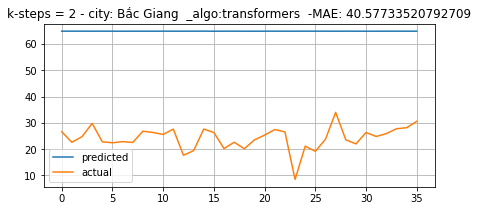

City: Bắc Giang  _algo:transformers  -MAE: 36.68440251835483


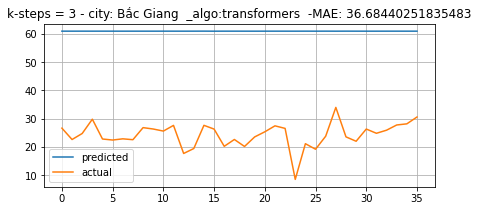

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 29.094807243800908


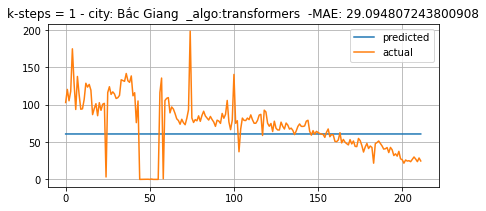

City: Bắc Giang  _algo:transformers  -MAE: 28.075728450622343


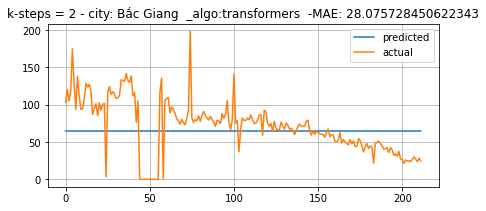

City: Bắc Giang  _algo:transformers  -MAE: 29.076118963916155


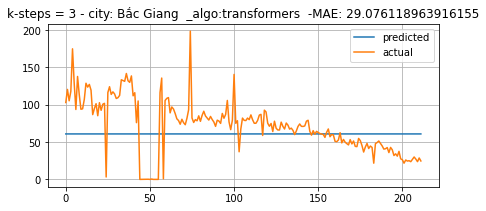

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Average_Humidity
Diarrhoea_rates
Bắc Giang
Epoch:  0/480 - train_loss: 1.3313 - test_loss: 0.878272
Epoch: 120/480 - train_loss: 0.3162 - test_loss: 0.426428
Epoch: 240/480 - train_loss: 0.2979 - test_loss: 0.467259
Epoch: 360/480 - train_loss: 0.3018 - test_loss: 0.468604
Epoch: 479/480 - train_loss: 0.3027 - test_loss: 0.458202
Evaluate on test set: 
City: Bắc Giang  _algo:transformers  -MAE: 38.893227130215614


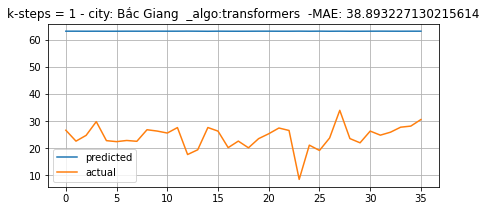

City: Bắc Giang  _algo:transformers  -MAE: 39.28242888087671


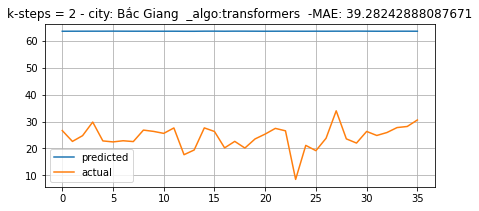

City: Bắc Giang  _algo:transformers  -MAE: 39.65202955739721


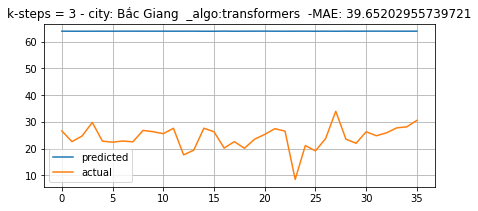

Evaluate on train set: 
City: Bắc Giang  _algo:transformers  -MAE: 28.473783737166556


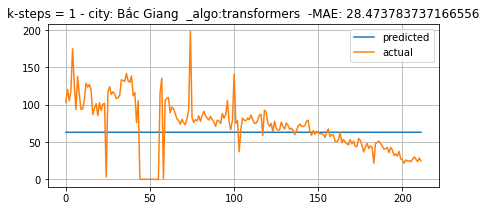

City: Bắc Giang  _algo:transformers  -MAE: 28.385925189881373


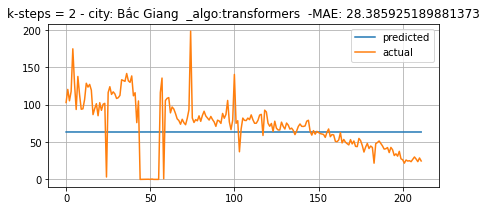

City: Bắc Giang  _algo:transformers  -MAE: 28.296056066917714


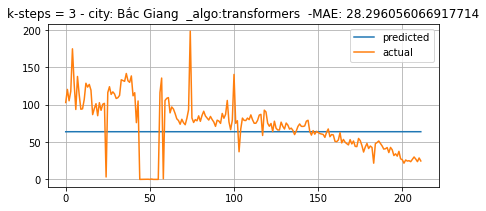

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Max_Average_Temperature
Min_Average_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/450 - train_loss: 1.1323 - test_loss: 0.746705
Epoch: 112/450 - train_loss: 0.3387 - test_loss: 0.291755
Epoch: 224/450 - train_loss: 0.3402 - test_loss: 0.274196
Epoch: 336/450 - train_loss: 0.3269 - test_loss: 0.268391
Epoch: 448/450 - train_loss: 0.3311 - test_loss: 0.280881
Epoch: 449/450 - train_loss: 0.3418 - test_loss: 0.283030
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 58.62288456539639


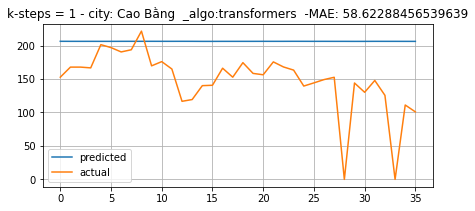

City: Cao Bằng  _algo:transformers  -MAE: 62.95950893204801


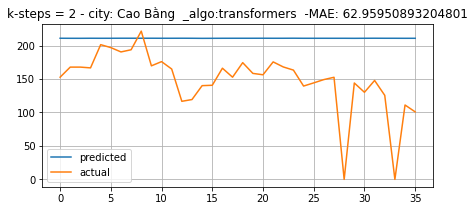

City: Cao Bằng  _algo:transformers  -MAE: 62.74656268760403


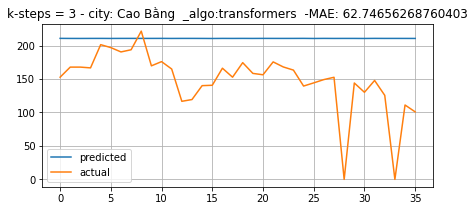

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 76.82030697859582


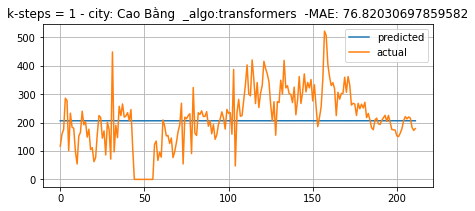

City: Cao Bằng  _algo:transformers  -MAE: 76.25593831691978


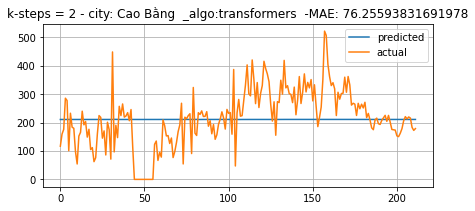

City: Cao Bằng  _algo:transformers  -MAE: 76.28804106793953


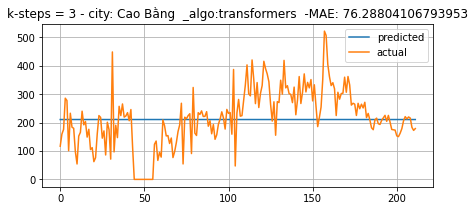

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Min_Average_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/450 - train_loss: 1.6606 - test_loss: 1.247592
Epoch: 112/450 - train_loss: 0.3288 - test_loss: 0.284296
Epoch: 224/450 - train_loss: 0.3335 - test_loss: 0.269247
Epoch: 336/450 - train_loss: 0.3355 - test_loss: 0.259179
Epoch: 448/450 - train_loss: 0.3361 - test_loss: 0.273102
Epoch: 449/450 - train_loss: 0.3351 - test_loss: 0.285731
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 64.72032105904012


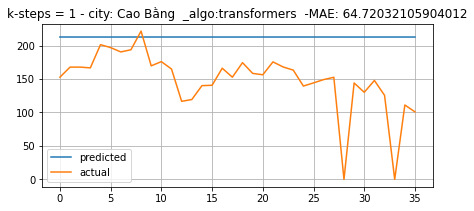

City: Cao Bằng  _algo:transformers  -MAE: 62.07707564357164


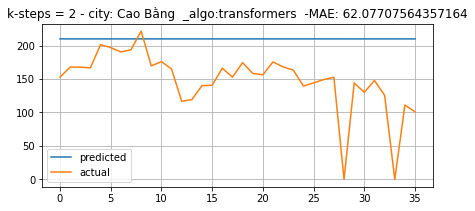

City: Cao Bằng  _algo:transformers  -MAE: 60.53087408081573


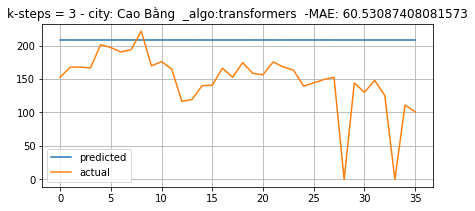

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 76.08645360916569


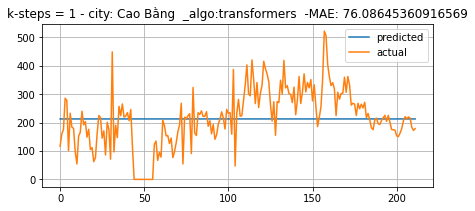

City: Cao Bằng  _algo:transformers  -MAE: 76.37175528387726


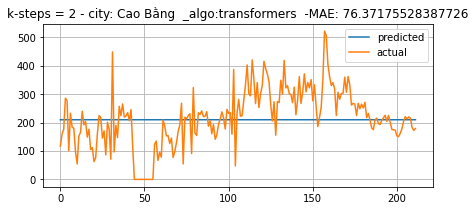

City: Cao Bằng  _algo:transformers  -MAE: 76.56784055818271


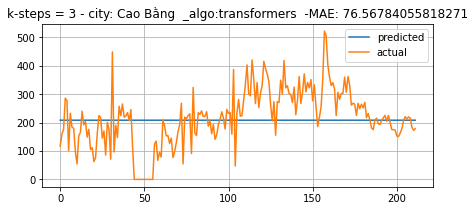

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Min_Average_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/450 - train_loss: 1.3519 - test_loss: 1.645502
Epoch: 112/450 - train_loss: 0.3327 - test_loss: 0.277006
Epoch: 224/450 - train_loss: 0.3432 - test_loss: 0.259276
Epoch: 336/450 - train_loss: 0.3368 - test_loss: 0.260730
Epoch: 448/450 - train_loss: 0.3303 - test_loss: 0.272017
Epoch: 449/450 - train_loss: 0.3586 - test_loss: 0.261870
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 62.29574167639535


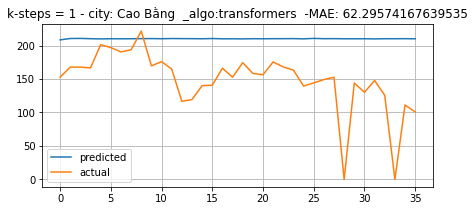

City: Cao Bằng  _algo:transformers  -MAE: 55.8743180213007


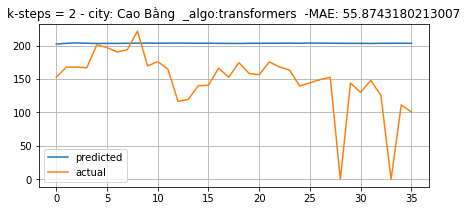

City: Cao Bằng  _algo:transformers  -MAE: 53.005622672325295


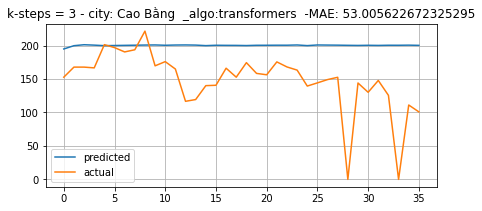

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 76.106210801808


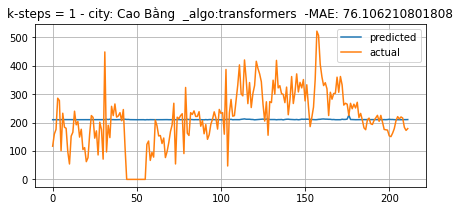

City: Cao Bằng  _algo:transformers  -MAE: 76.96895770911448


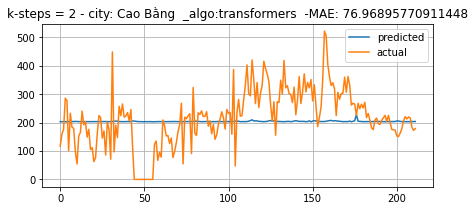

City: Cao Bằng  _algo:transformers  -MAE: 77.98712262091126


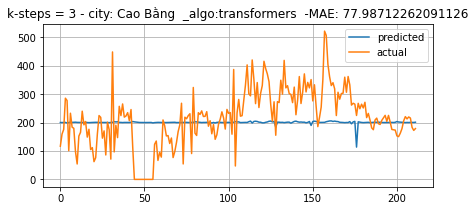

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Min_Average_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/450 - train_loss: 1.1896 - test_loss: 0.941811
Epoch: 112/450 - train_loss: 0.3792 - test_loss: 0.281938
Epoch: 224/450 - train_loss: 0.3347 - test_loss: 0.300065
Epoch: 336/450 - train_loss: 0.3257 - test_loss: 0.298828
Epoch: 448/450 - train_loss: 0.3523 - test_loss: 0.261967
Epoch: 449/450 - train_loss: 0.3377 - test_loss: 0.261673
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 59.97741644537742


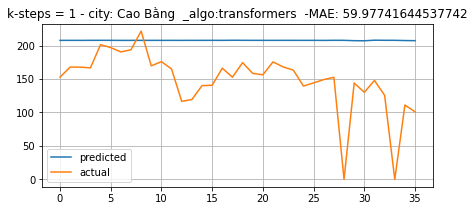

City: Cao Bằng  _algo:transformers  -MAE: 62.169115859482076


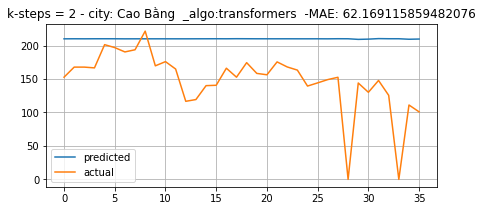

City: Cao Bằng  _algo:transformers  -MAE: 58.802564336576275


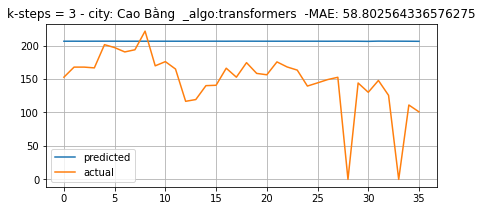

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 76.63735036553781


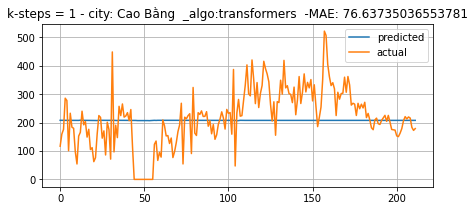

City: Cao Bằng  _algo:transformers  -MAE: 76.35313103802031


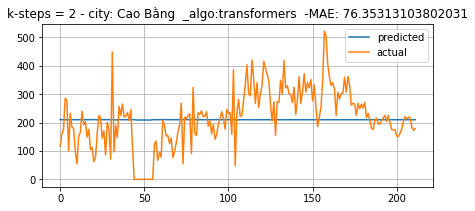

City: Cao Bằng  _algo:transformers  -MAE: 76.8336474443463


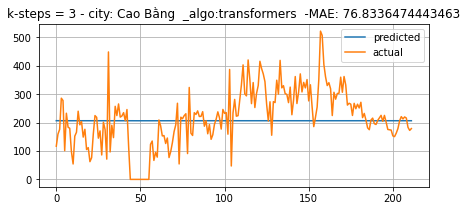

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Max_Average_Temperature
Min_Average_Temperature
Diarrhoea_rates
Cao Bằng
Epoch:  0/450 - train_loss: 0.9786 - test_loss: 0.780898
Epoch: 112/450 - train_loss: 0.3232 - test_loss: 0.269160
Epoch: 224/450 - train_loss: 0.3347 - test_loss: 0.263030
Epoch: 336/450 - train_loss: 0.3584 - test_loss: 0.273298
Epoch: 448/450 - train_loss: 0.3286 - test_loss: 0.275851
Epoch: 449/450 - train_loss: 0.3312 - test_loss: 0.273423
Evaluate on test set: 
City: Cao Bằng  _algo:transformers  -MAE: 60.827069721383424


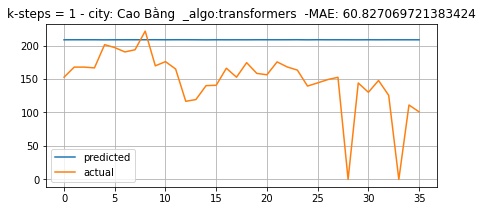

City: Cao Bằng  _algo:transformers  -MAE: 57.18571221535282


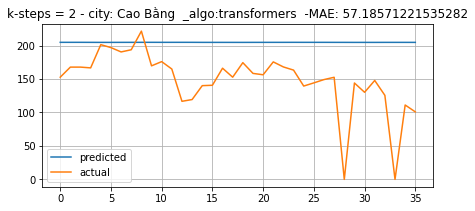

City: Cao Bằng  _algo:transformers  -MAE: 64.37754757569924


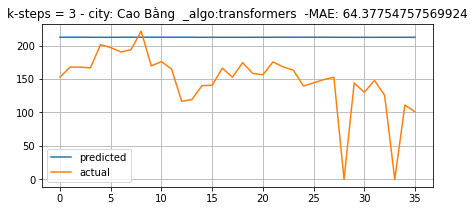

Evaluate on train set: 
City: Cao Bằng  _algo:transformers  -MAE: 76.48982011536059


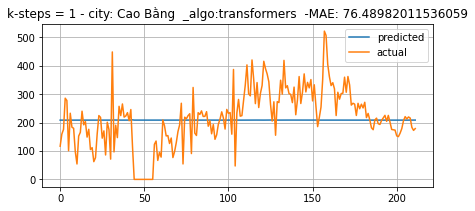

City: Cao Bằng  _algo:transformers  -MAE: 77.07208373043292


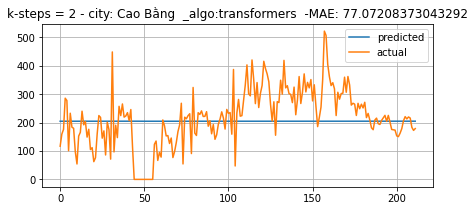

City: Cao Bằng  _algo:transformers  -MAE: 76.06503149950963


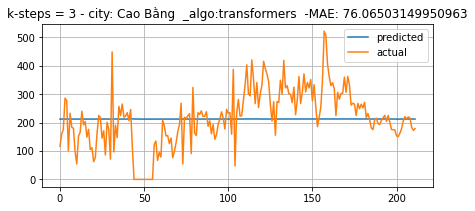

<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

lookback 3
Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/240 - train_loss: 1.0264 - test_loss: 0.609760
Epoch: 60/240 - train_loss: 0.2155 - test_loss: 0.242638
Epoch: 120/240 - train_loss: 0.2291 - test_loss: 0.246735
Epoch: 180/240 - train_loss: 0.2128 - test_loss: 0.276906
Epoch: 239/240 - train_loss: 0.2211 - test_loss: 0.269430
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 23.831068629742582


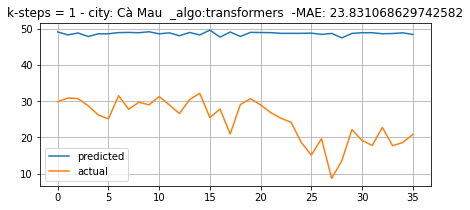

City: Cà Mau  _algo:transformers  -MAE: 23.033211029957116


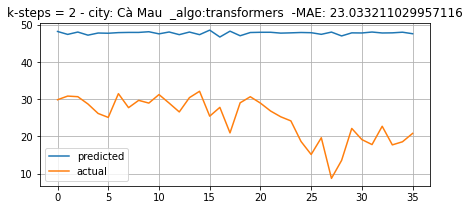

City: Cà Mau  _algo:transformers  -MAE: 21.062151218696265


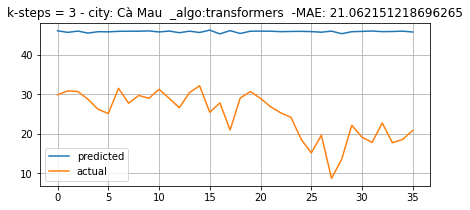

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 19.798446237508596


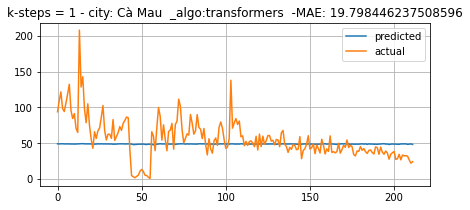

City: Cà Mau  _algo:transformers  -MAE: 19.914512991441107


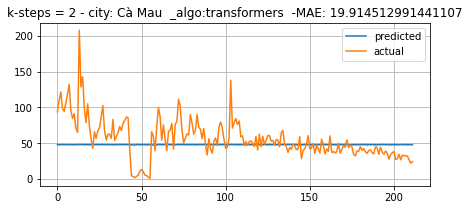

City: Cà Mau  _algo:transformers  -MAE: 20.192430583417323


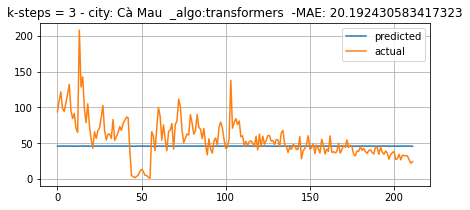

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/240 - train_loss: 1.1162 - test_loss: 0.857581
Epoch: 60/240 - train_loss: 0.2143 - test_loss: 0.254298
Epoch: 120/240 - train_loss: 0.2258 - test_loss: 0.280285
Epoch: 180/240 - train_loss: 0.2167 - test_loss: 0.281870
Epoch: 239/240 - train_loss: 0.2129 - test_loss: 0.246648
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 15.121108603008262


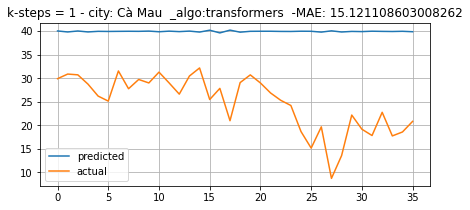

City: Cà Mau  _algo:transformers  -MAE: 24.802375261720858


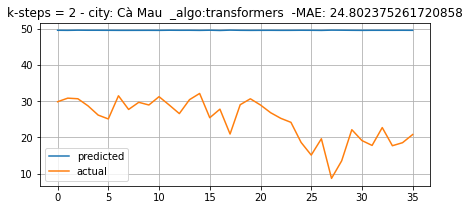

City: Cà Mau  _algo:transformers  -MAE: 26.87100098899544


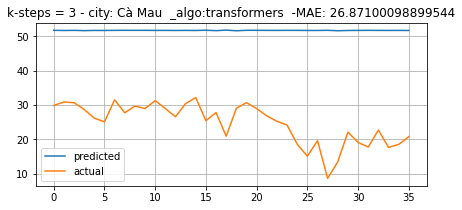

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 22.059891452767793


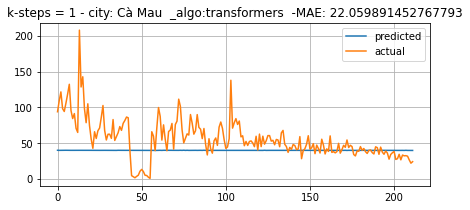

City: Cà Mau  _algo:transformers  -MAE: 19.85887871894819


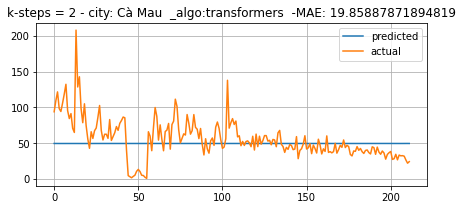

City: Cà Mau  _algo:transformers  -MAE: 19.816486237499248


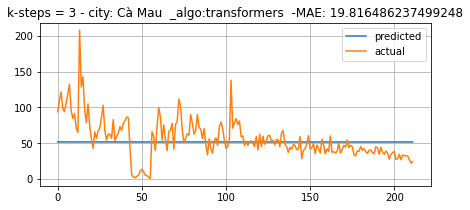

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/240 - train_loss: 1.1212 - test_loss: 0.734950
Epoch: 60/240 - train_loss: 0.2288 - test_loss: 0.273203
Epoch: 120/240 - train_loss: 0.2117 - test_loss: 0.260566
Epoch: 180/240 - train_loss: 0.2227 - test_loss: 0.247956
Epoch: 239/240 - train_loss: 0.2229 - test_loss: 0.267232
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 28.082674083899278


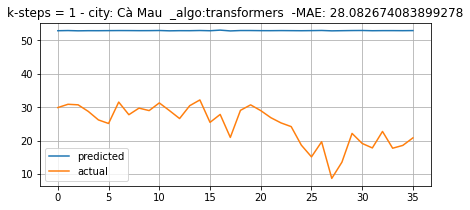

City: Cà Mau  _algo:transformers  -MAE: 24.989058835032843


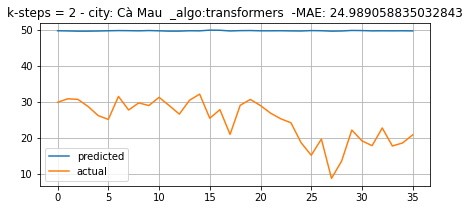

City: Cà Mau  _algo:transformers  -MAE: 22.09384978595805


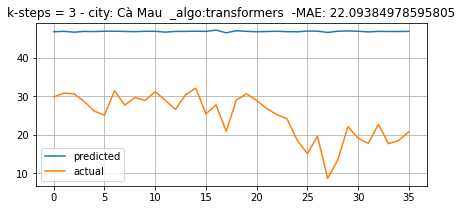

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 19.842866799610416


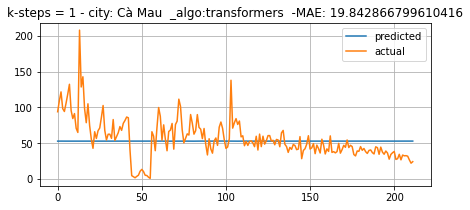

City: Cà Mau  _algo:transformers  -MAE: 19.846267431170922


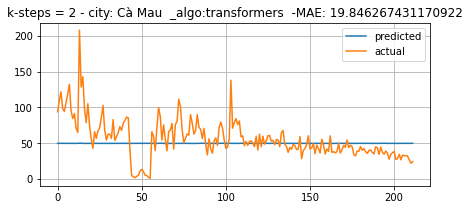

City: Cà Mau  _algo:transformers  -MAE: 20.047826748600254


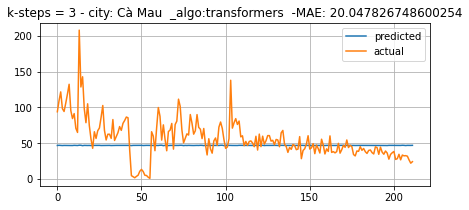

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/240 - train_loss: 0.9432 - test_loss: 0.831940
Epoch: 60/240 - train_loss: 0.2135 - test_loss: 0.282775
Epoch: 120/240 - train_loss: 0.2756 - test_loss: 0.265074
Epoch: 180/240 - train_loss: 0.2239 - test_loss: 0.271210
Epoch: 239/240 - train_loss: 0.2231 - test_loss: 0.269044
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 14.66208179012764


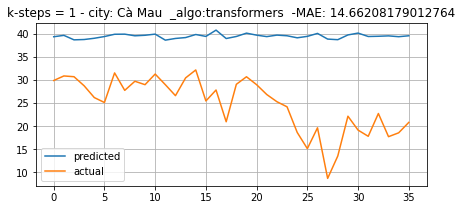

City: Cà Mau  _algo:transformers  -MAE: 13.872094508227388


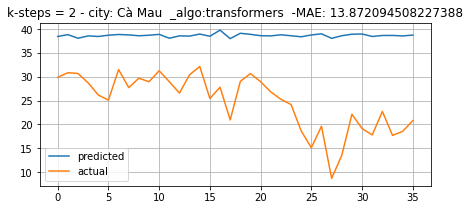

City: Cà Mau  _algo:transformers  -MAE: 25.477889446588716


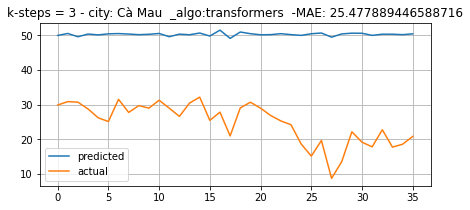

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 22.29228306301828


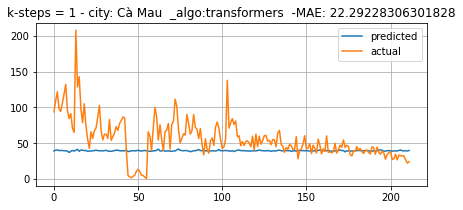

City: Cà Mau  _algo:transformers  -MAE: 22.745565922475425


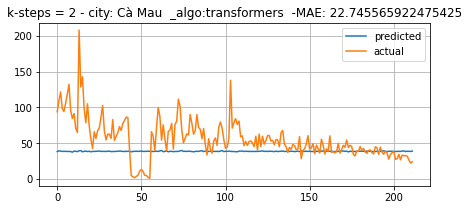

City: Cà Mau  _algo:transformers  -MAE: 19.866856184543884


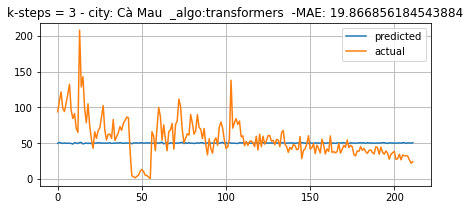

lookback 3


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

Important Feature:
Total_Evaporation
Max_Daily_Rainfall
Diarrhoea_rates
Cà Mau
Epoch:  0/240 - train_loss: 1.0662 - test_loss: 0.847651
Epoch: 60/240 - train_loss: 0.2184 - test_loss: 0.238040
Epoch: 120/240 - train_loss: 0.2302 - test_loss: 0.264857
Epoch: 180/240 - train_loss: 0.2117 - test_loss: 0.273583
Epoch: 239/240 - train_loss: 0.2375 - test_loss: 0.237151
Evaluate on test set: 
City: Cà Mau  _algo:transformers  -MAE: 22.64612710889513


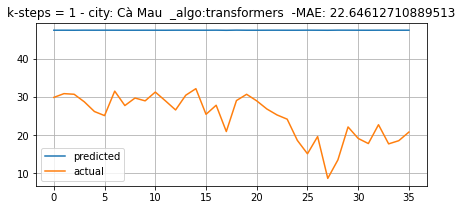

City: Cà Mau  _algo:transformers  -MAE: 29.51077036568283


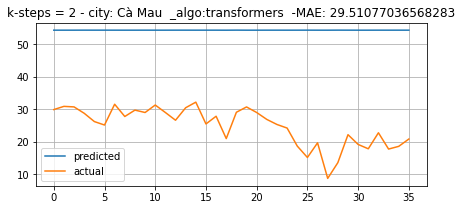

City: Cà Mau  _algo:transformers  -MAE: 25.45834054987268


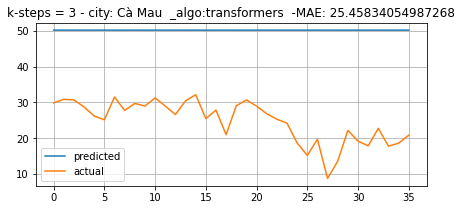

Evaluate on train set: 
City: Cà Mau  _algo:transformers  -MAE: 19.978390244701835


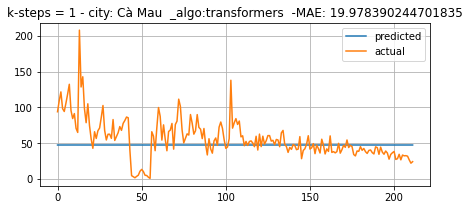

City: Cà Mau  _algo:transformers  -MAE: 19.918887199823917


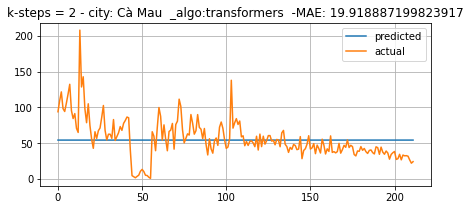

City: Cà Mau  _algo:transformers  -MAE: 19.83487448873316


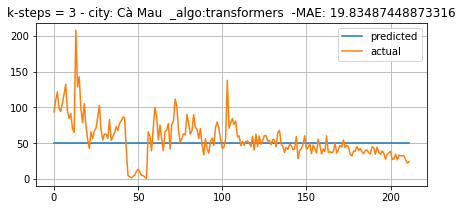

kết thúc train trong: 58
danh sách error city: 
{}


<ipython-input-19-38cfc4c32612>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Train Prediction'][lookback_window:lookback_window+y_pred_train[0].size] = y_pred_train[0]
<ipython-input-19-38cfc4c32612>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mix_train_test_result['Test Prediction'].iloc[-(y_pred_test[0].size):] = y_pred_test[0]
<ipython-input-21-261867baa2d7>:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer'

In [21]:
dt_started = datetime.now()
################################################
## Main run all city for Transformer
################################################
n_LoopEachExpRun = 5
expRuntime = 0 # basicly just increase each time

cities = [
#     'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định', 
    'Đà Nẵng',
'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
]

# 'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định', 'Đà Nẵng'
# 'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',

# 'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh', 'Hòa Bình',
# 'Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',

# 'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng', 'Đắk Nông'
# 'Lạng Sơn', 'Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',

# 'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi', 'Đắk Lắk'
# 'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',

# 'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh', 'Đồng Tháp'
# 'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',


l_errCity = {}
# Với mỗi thành phố ta sẽ chạy n_LoopEachExpRun lần ứng với từng giải thuật.
# Nếu chỉ chạy 1 lần thì để n_LoopEachExpRun = 0

for city in cities:
  try:
    
    total_result = pd.DataFrame() # final result cho mỗi thành phố of all runninng time
    total_metrix_result = pd.DataFrame() # final metrix result cho mỗi thành phố of all runninng time
    mix_train_test_result_tf=pd.DataFrame()

    for interation in range(n_LoopEachExpRun):
      
      # Pre-process data
      specific_data = get_city_data(fix_text(city))
      specific_data = impute_missing_value(specific_data)
      specific_data = convert_to_stationary(specific_data)
      specific_data.dropna(inplace=True)
      
      # Get right optimize parame
      n_layers, hidden_size, _, dropout, learning_rate, epoch, lookback_window = get_opt_param_by_name(algo='transformer', city=city)
      
      train, test = split_data(specific_data,lookback_window)

      # Fit data scaler to training data
      full_scaler = MinMaxScaler().fit(train)
      y_scaler = MinMaxScaler().fit(train.values[:, -1].reshape(-1, 1))

      # Scale train and test data
      train = full_scaler.transform(train)
      test = full_scaler.transform(test)

      # Get data to run model
      important_features, train_loader, test_tensor = get_data(train, test, args.batch_size, specific_data)

      # Overwrite parameters for province-specific diarrhoea prediction
      args.look_back = lookback_window
      print(city)
      trainer = Trainer(
                      model_type='transformers',
                      city = city, 
                      learning_rate=learning_rate,
                      important_features=important_features,
                      train_loader=train_loader,
                      test_tensor=test_tensor,
                      n_layers=n_layers,
                      hidden_size=hidden_size,
                      dropout=dropout)

      # Train model with province-specific epochs
      trainer.train(epochs=epoch)

      print("Evaluate on test set: ")
      y_true_test, y_pred_test, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, plot= True, scaled=True, city=city, y_scaler= y_scaler)

      print("Evaluate on train set: ")
      y_true_train, y_pred_train,  _, _, _, = trainer.evaluate_model(np_data=train, plot=True, scaled=True, city=city, y_scaler= y_scaler)

      # Lưu tất cả kết quả predicted train và predicted test
      mix_train_test_result_tf = mix_train_test_result_tf.append(mix_results(city,'transformer', specific_data, y_pred_test, 
                                                                              y_pred_train,lookback_window,interation, rmse_list[0],mae_list[0],mape_list[0])) 


      transformer_reslt = pd.DataFrame({
                                'City': city,
                                'Alg_name': 'transformers',
                                'Run Seq': interation,
                                'Observed': y_true_test[0], 
                                '1-month': y_pred_test[0], 
                                '2-months': y_pred_test[1],
                                '3-months': y_pred_test[2],
                                'RMSE_1-month': rmse_list[0],
                                'RMSE_2-month': rmse_list[1],
                                'RMSE_3-month': rmse_list[2],
                                'MAE_1-month': mae_list[0],
                                'MAE_2-month': mae_list[1],
                                'MAE_3-month': mae_list[2],
                                'MAPE_1-month': mape_list[0],
                                'MAPE_2-month': mape_list[1],
                                'MAPE_3-month': mape_list[2]})

      transformer_metrix_reslt = pd.DataFrame({
                                'City': city,
                                'Alg_name': 'transformers',
                                'Run Seq': interation,                          
                                'RMSE_1-month': rmse_list[0],
                                'RMSE_2-month': rmse_list[1],
                                'RMSE_3-month': rmse_list[2],
                                'MAE_1-month': mae_list[0],
                                'MAE_2-month': mae_list[1],
                                'MAE_3-month': mae_list[2],
                                'MAPE_1-month': mape_list[0],
                                'MAPE_2-month': mape_list[1],
                                'MAPE_3-month': [mape_list[2]]}) # do có 1 dòng nên pandas cần index = 0
      
      total_result = total_result.append(pd.DataFrame(transformer_reslt))
      total_metrix_result = total_metrix_result.append(pd.DataFrame(transformer_metrix_reslt))
    
    # Lưu xuống file excel ứng với từng thành phố
    total_result.to_excel(path+'/tf/diarrhoea_transformer_'+city+'_'+str(expRuntime)+'.xlsx')  
    total_metrix_result.to_excel(path_metrix+'/tf/diarrhoea_metrix_transformer_'+city+'_'+str(expRuntime)+'.xlsx')
    
    # Lưu xuống mix predicted train và test data ứng với từng thành phố/ từng giải thuật
    save_results(mix_train_test_result_tf,'tf', city)
  except Exception as e:
    l_errCity[city] = e
    break

dt_ended = datetime.now()
print('kết thúc train trong:', round((dt_ended - dt_started).total_seconds()/60))
print ('danh sách error city: ')
print(l_errCity)

In [22]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        print(e)

send_to_telegram("TEST\nList city:\n" + ',\n'.join(str(city) for city in cities) + "\nalgo: transformer ntry = 10" )

{"ok":true,"result":{"message_id":463,"sender_chat":{"id":-1001712314864,"title":"PTN_Announcement","username":"ptn_announcement","type":"channel"},"chat":{"id":-1001712314864,"title":"PTN_Announcement","username":"ptn_announcement","type":"channel"},"date":1676167796,"text":"TEST\nList city:\n\u0110\u00e0 N\u1eb5ng,\nB\u1ea1c Li\u00eau,\nB\u1eafc K\u1ea1n,\nB\u1eafc Giang,\nCao B\u1eb1ng,\nC\u00e0 Mau\nalgo: transformer ntry = 10"}}
